- Discuss about the convolution methods fft, direct (see end of VG notebook) and with the matrix J
- Discuss about the approximations of m

In [1]:
from scipy import sparse
from scipy.sparse.linalg import splu

import numpy as np
import scipy as scp
import scipy.stats as ss
from IPython.display import display
import sympy; sympy.init_printing()
from scipy import signal
from scipy.integrate import quad
import matplotlib.pyplot as plt

def display_matrix(m):
    display(sympy.Matrix(m))

In [2]:
r = 0.1; sig = 0.2                
S0 = 100; X0 = np.log(S0)          
K = 100; Texpir = 1            

lam = 0.8; muJ = 0; sigJ = 0.5 

Nspace = 16000   # M space steps  5 
Ntime = 12000    # N time steps   3
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

dx = (x_max - x_min)/(Nspace-1)
extraP = int(np.floor(3*sigJ/dx))  ############### CORREGGI
x = np.linspace(x_min-extraP*dx, x_max+extraP*dx, Nspace + 2*extraP)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization

In [3]:
extraP

In [17]:
Payoff = np.maximum(np.exp(x)-K,0)             # Call payoff
V = np.zeros((Nspace + 2*extraP, Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms

In [18]:
V[:,-1] = Payoff                   # terminal conditions 
V[-extraP-1:,:] = np.exp(x[-extraP-1:]).reshape(extraP+1,1) * np.ones((extraP+1,Ntime)) - \
                 K * np.exp(-r* T[::-1] ) * np.ones((extraP+1,Ntime))  # boundary condition
V[:extraP+1,:] = 0

In [19]:
cdf = ss.norm.cdf([np.linspace(-(extraP+1+0.5)*dx, (extraP+1+0.5)*dx, 2*(extraP+2) )], loc=muJ, scale=sigJ)[0]
nu = lam * (cdf[1:] - cdf[:-1])

In [20]:
lam_appr = sum(nu)
print("Truncated jump activity: ", lam_appr)

m = lam * (np.exp(muJ + (sigJ**2)/2) -1)
print("True value: ", m)
m_int = quad(lambda z: lam * (np.exp(z)-1) * ss.norm.pdf(z,muJ,sigJ), -(extraP+1.5)*dx, (extraP+1.5)*dx )[0]
print("Truncated value: ", m_int)
m_appr = np.array([ np.exp(i*dx)-1 for i in range(-(extraP+1), extraP+2)]) @ nu
print("Approximation value: ", m_appr)

Truncated jump activity:  0.7999496772796824
True value:  0.10651876245346106
Truncated value:  0.10635644455202968
Approximation value:  0.10635645612875452


In [21]:
# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx
a = ( (dt/2) * ( (r-m_appr-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r + lam_appr) )
c = (-(dt/2) * ( (r-m_appr-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

In [30]:
J = np.zeros((Nspace-2, Nspace + 2*extraP))

for i in range(Nspace-2):
    J[i, i:(len(nu)+i)] = nu

In [31]:
#display_matrix(J)

In [32]:
#display_matrix(V)

In [33]:
%%time
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * (J @ V[:,i+1])
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset )    

CPU times: user 3min 59s, sys: 6.47 s, total: 4min 5s
Wall time: 1min 2s


In [34]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

21.996790482861428


In [22]:
%%time 
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * signal.fftconvolve(V[:,i+1],nu,mode="valid")
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset )    

CPU times: user 4.8 s, sys: 28 ms, total: 4.83 s
Wall time: 4.83 s


In [23]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

22.00433586093113


In [15]:
J.shape

In [17]:
J @ V[:,-1]

array([  0.95754373,   2.88942592,   7.40140584,  16.36162295,
        31.81654344,  55.59075418,  89.20798715, 134.23900835])

In [19]:
VV = V[:,-1]

In [53]:
from scipy import signal

In [40]:
convol = signal.fftconvolve(VV,nu,mode="valid")
convol

array([  0.95754373,   2.88942592,   7.40140584,  16.36162295,
        31.81654344,  55.59075418,  89.20798715, 134.23900835])

In [ ]:
Merton.mesh_plt()

In [119]:
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process, Merton_process
from functions.BS_pricer import BS_pricer
from functions.Merton_pricer import Merton_pricer 
import numpy as np
import matplotlib.pyplot as plt

In [120]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=15, K=15, T=1, exercise="European", payoff="call" )

# Creates the object with the parameters of the process
Merton_param = Merton_process(r=0.1, sig=0.1, lam=0.01, muJ=0, sigJ=1.8)
diff_param = Diffusion_process(r=0.1, sig=np.sqrt(Merton_param.var))

print("standard deviation: ", np.sqrt(Merton_param.var) )
print("kurtosis: ", Merton_param.kurt)

# Creates the object of the pricer
BS = BS_pricer(opt_param, diff_param)
Merton = Merton_pricer(opt_param, Merton_param)

standard deviation:  0.20591260281974003
kurtosis:  97.32111071555713


In [121]:
Merton.closed_formula()

1.7045338911636234

In [122]:
BS.closed_formula()

2.0201067538351616

In [123]:
BS.PDE_price((6000,3000), Time=True)

(2.020050559329645, 0.8478083610534668)

In [124]:
Merton.PIDE_price((6000,3000), Time=True)

(1.7043241984876165, 18.34526562690735)

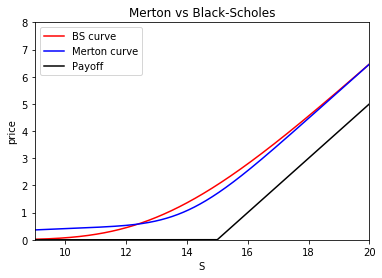

In [128]:
plt.plot(BS.S_vec, BS.price_vec, color='red',label="BS curve")
plt.plot(Merton.S_vec, Merton.price_vec, color='blue',label="Merton curve")
plt.plot(Merton.S_vec, Merton.payoff_f(Merton.S_vec), color='black',label="Payoff")
plt.axis([9,20,0,8])
plt.xlabel("S"); plt.ylabel("price"); plt.title("Merton vs Black-Scholes")
plt.legend()
#plt.savefig("Mert-BS_same_var.png")

In [12]:
#Merton.plot(axis=[40,250,0,150])
#BS.plot(axis=[40,250,0,150])